In [172]:
import os
import sys
from hydromt_sfincs import SfincsModel
import matplotlib.pyplot as plt

Create grid from scratch

In [173]:
# Initialize SfincsModel with the artifact data catalog which contains data for North Italy
sf = SfincsModel(data_libs=["artifact_data"], root="sfincs_compound5")

In [174]:
#inp_dict = {
    #"x0": 268650,
    #"y0": 5018550,
    #"dx": 150.0,
    #"dy": 150.0,
    #"nmax": 272,
    #"mmax": 425,
    #"rotation": 0,
    #"epsg": 32633,
#}
inp_dict = {
    "x0": 310000,   #315000
    "y0": 5040000,
    "dx": 100.0,
    "dy": 100.0,
    "nmax": 250,
    "mmax": 250,
    "rotation": 0,
    "epsg": 32633,
}
# create grid
sf.create_grid(grid_type="regular", **inp_dict)

# the input file is automatically updated
sf.config

{'mmax': 250,
 'nmax': 250,
 'dx': 100.0,
 'dy': 100.0,
 'x0': 310000,
 'y0': 5040000,
 'rotation': 0,
 'latitude': 0.0,
 'tref': datetime.datetime(2010, 2, 1, 0, 0),
 'tstart': datetime.datetime(2010, 2, 1, 0, 0),
 'tstop': datetime.datetime(2010, 2, 2, 0, 0),
 'tspinup': 60.0,
 'dtmapout': 600.0,
 'dthisout': 600.0,
 'dtrstout': 0.0,
 'dtmaxout': 0.0,
 'trstout': -999.0,
 'dtwnd': 1800.0,
 'alpha': 0.75,
 'theta': 0.9,
 'huthresh': 0.01,
 'manning': 0.04,
 'manning_land': 0.04,
 'manning_sea': 0.02,
 'rgh_lev_land': 0.0,
 'zsini': 0.0,
 'qinf': 0.0,
 'igperiod': 120.0,
 'rhoa': 1.25,
 'rhow': 1024.0,
 'dtmax': 999.0,
 'maxlev': 999.0,
 'bndtype': 1,
 'advection': 0,
 'baro': 0,
 'pavbnd': 0,
 'gapres': 101200.0,
 'advlim': 9999.9,
 'stopdepth': 1000.0,
 'crsgeo': 0,
 'inputformat': 'bin',
 'outputformat': 'net',
 'cdnrb': 3,
 'cdwnd': [0.0, 28.0, 50.0],
 'cdval': [0.001, 0.0025, 0.0015],
 'epsg': 32633}

Create mask of active and inactive cells

TODO - Add Explain mask options

In [175]:
#mask = sf.create_mask_active()
#mask.plot.imshow()

Now provide arguments to make a mask that includes active cells

Based on elevation --> will give an error because we need elevation data

In [176]:
#mask = sf.create_mask_active(elv_min=-5, elv_max=10)
#mask.plot.imshow()

Also take into account topobathy information

In [177]:
#we would like to use the region to get raster data
#so reset region, otherwise region is only part of grid
region = sf.reggrid.empty_mask.raster.box
sf.set_geoms(region, "region")

#QUESTION > is this still needed?

In [178]:
# sf.grid.data.raster.set_crs(sf.grid.crs)
da_dep1 = sf.data_catalog.get_rasterdataset(
    "merit_hydro", variables=["elevtn"], geom=sf.region, buffer=5
)

da_dep2 = sf.data_catalog.get_rasterdataset(
    "gebco", variables=["elevtn"], geom=sf.region, buffer=5
)

# Provide merge arguments together with xr.DataAraay
da_dep_lst = [{"da":da_dep1}, {"da":da_dep2, "zmax":0, "offset":0}]

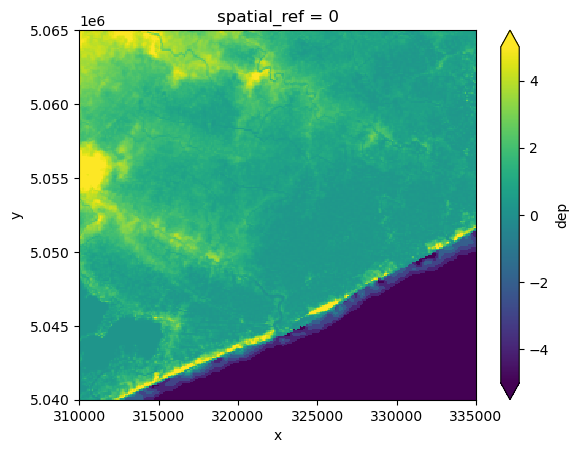

In [179]:
# Add depth information to modelgrid based on these chosen datasets
dep = sf.create_dep(da_dep_lst=da_dep_lst)
# plot
dep.plot(vmin=-5, vmax=5)#, cmap='RdBu_r')

#sf.plot_basemap()


3 gaps outside valid elevation range < 10 km2.


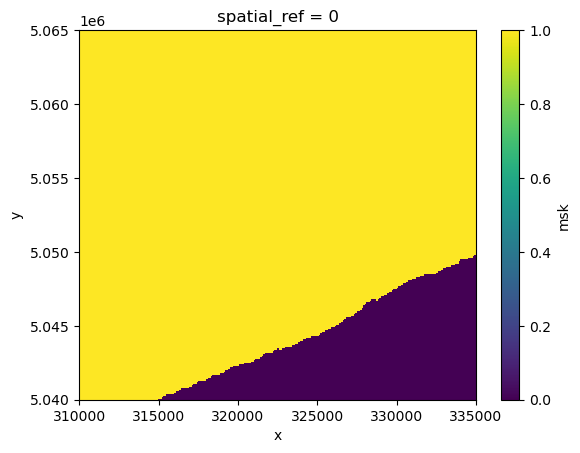

In [200]:

mask = sf.create_mask_active( elv_min=-5) #drop_area=10, fill_area=10, connectivity=4, reset_mask=True)
# plot:
mask.plot.imshow()

In [181]:
#update mask; NOTE reset_mask=False by default
# mask = sf.create_mask_active(gdf_exclude=gdf_exclude)
# mask.plot.imshow()

Mask boundaries

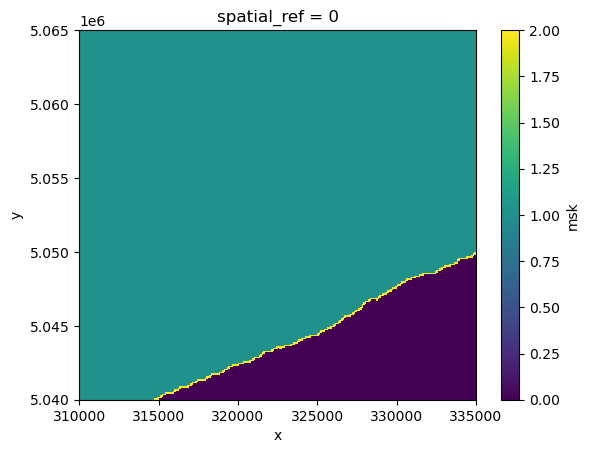

In [201]:
sf.create_mask_bounds(btype="waterlevel", elv_max=-5, reset_bounds=True)

sf.mask.plot(x='x', y='y')

In [202]:
#reset outflow bounds
#sf.create_mask_bounds(btype="outflow", reset_bounds=True)
#sf.create_mask_bounds(btype="outflow", elv_min=2, reset_bounds=True)
#sf.mask.plot.imshow()

Add some water level focing at sea:

In [204]:
import xarray as xr
import pandas as pd
time = pd.date_range("2000-01-01", freq="H", periods=365 * 24)

ds = xr.Dataset({"time": time, 'index': [1,2]})
ds.asign_coords({'x': ('index', [x1, x2])})
ds.asign_coords({'y': ('index', [y1, y2])})


<xarray.Dataset>
Dimensions:  (time: 8760)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-12-30T23:00:00
Data variables:
    *empty*

In [203]:
sf.setup_h_forcing()

#sf.forcing["bzs"]

KeyError: 'bzs'

Add a discharge input point upstream:

#### subgrid

In [184]:
#Number of regular cells in a block : 100
#Number of blocks in n direction    : 3
#Number of blocks in m direction    : 5
#Grid size of flux grid            : dx=150.0, dy=150.0
#Grid size of subgrid pixels       : dx=7.5, dy=7.5

#block 1/15 -- col 0:99 | row 0:99
#Processing block with 9767 active cells ..

#block 2/15 -- col 0:99 | row 100:199
#Processing block with 3120 active cells ..

#sf.create_subgrid(da_dep_lst=da_dep_lst, make_dep_tiles=True)

# TODO explain feedback
# TODO explain nr_subgrid_pixels
# TODO explain created files

In [185]:
#sf.subgrid["z_zmin"].plot.imshow()

### write

In [186]:
sf.write_grid(data_vars=["dep"])  # write single grid map > if subgrid model only a sfincs.ind is written away

In [187]:
sf.write() # write all